___
<h1><center> Problema de regresión</center></h1>

___


### Descripción del problema:
Inferencia del valor de las casas en Boston.

El objetivo del problema es predecir el valor de una vivienda usando sus características. 

Haremos uso del dataset Boston. Este dataset está incluido dentro de **sklearn**, aunque la fuente original es de la University of California Irvine (**Url:** https://archive.ics.uci.edu/ml/machine-learning-databases/housing/)

<img src='hose.JPG'></img>

### Descripción del dataset:

Cuenta con un total de **13 variables predictoras X** y una **variable continua a predecir Y**.

El número total de muestras es de 506 casas.

**Información de las variables:**

1. CRIM: tasa de criminalidad per cápita por ciudad
2. ZN: proporción de parcelas de más de 25,000 pies cuadrados. 
3. INDUS: proporción de acres de negocios no minoristas por ciudad
4. CHAS: variable categórica Charles River (= 1 si la casa limita con el río; 0 no limita) 
5. NOX: concentración de óxidos nítricos (partes por 10 millones)
6. RM: número promedio de habitaciones por vivienda
7. AGE: proporción de unidades ocupadas por sus propietarios construidas antes de 1940
8. DIS: distancias ponderadas a cinco centros de empleo de Boston
9. RAD: índice de accesibilidad a carreteras radiales 
10. TAX: tasa de impuesto a la propiedad de valor total por \$ 10.000 
11. PTRATIO: ratio alumno-profesor por localidad
12. B: 1000(Bk - 0.63)^2 donde Bk es la proporción de personas de raza negra por pueblo
13. LSTAT: % menor estado de la población
14. MEDV: Valor medio de viviendas ocupadas por sus propietarios en \$1000's

# Carga de librerías:

In [1]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from IPython.core.display import display, HTML
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Definición de funciones: 

In [2]:
def relaciones_vs_target_reg(X, Y, return_type='axes'):
    '''
    Función que representa gráficos de dispersión de las variables
    en X en función a la variable Y
    '''
    fig_tot = (len(X.columns))
    fig_por_fila = 4.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.regplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()
    
    
def represento_historico(historico):
    hist = pd.DataFrame(historico.history)
    hist['epoch'] = historico.epoch

    plt.figure(figsize=(15,7))
    plt.xlabel('Epoch')
    plt.ylabel('Error absoluto medio [MAE]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Error de entrenamiento')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Error de validación')
    plt.title('Error MAE en entrenamiento y en test')
    plt.ylim([0,5])
    plt.legend()

    plt.figure(figsize=(15,7))
    plt.xlabel('Epoch')
    plt.ylabel('Error cuadrático medio [MSE]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Error de entrenamiento')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Error de validación')
    plt.title('Error MSE en entrenamiento y en test')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

# Lectura de datos:

In [3]:
diccionario = load_boston()
X = pd.DataFrame(diccionario['data'],columns=diccionario['feature_names'])
Y = diccionario['target']
XY = pd.concat([X,pd.Series(Y, name='target')],axis=1)

In [4]:
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Los nombres de las variables independientes son: {}'.format(list(X.columns)))
XY[:2]

- El número de filas en el dataset es: 506
- El número de columnas en el dataset es: 14
- Los nombres de las variables independientes son: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6


# Visualizaciones y correlaciones

## Descriptivos básicos:

In [5]:
XY.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Boxplots: 

In [6]:
X_normalizado = (X-X.mean())/X.std()

In [7]:
X_normalizado[:2]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.419367,0.284548,-1.286636,-0.272329,-0.144075,0.413263,-0.119895,0.140075,-0.981871,-0.665949,-1.457558,0.440616,-1.074499
1,-0.416927,-0.487240,-0.592794,-0.272329,-0.739530,0.194082,0.366803,0.556609,-0.867024,-0.986353,-0.302794,0.440616,-0.491953


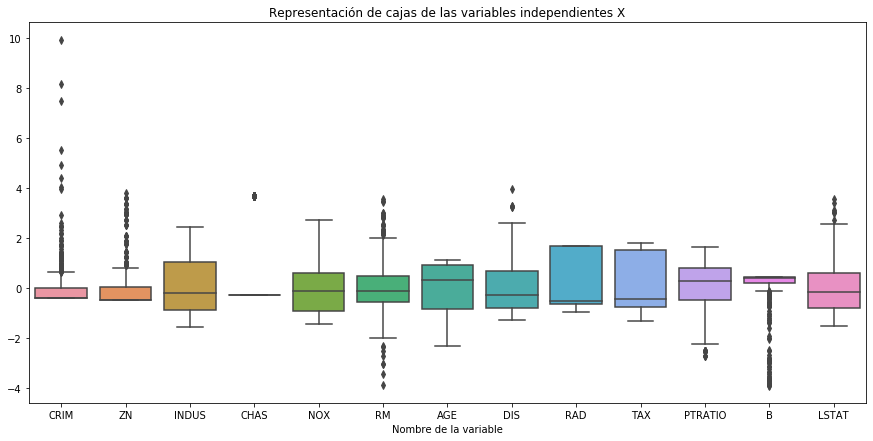

In [8]:
plt.figure(figsize=(15,7))
sns.boxplot(data=X_normalizado)
plt.title(u'Representación de cajas de las variables independientes X')
_ = plt.xlabel('Nombre de la variable')

## Histogramas: 

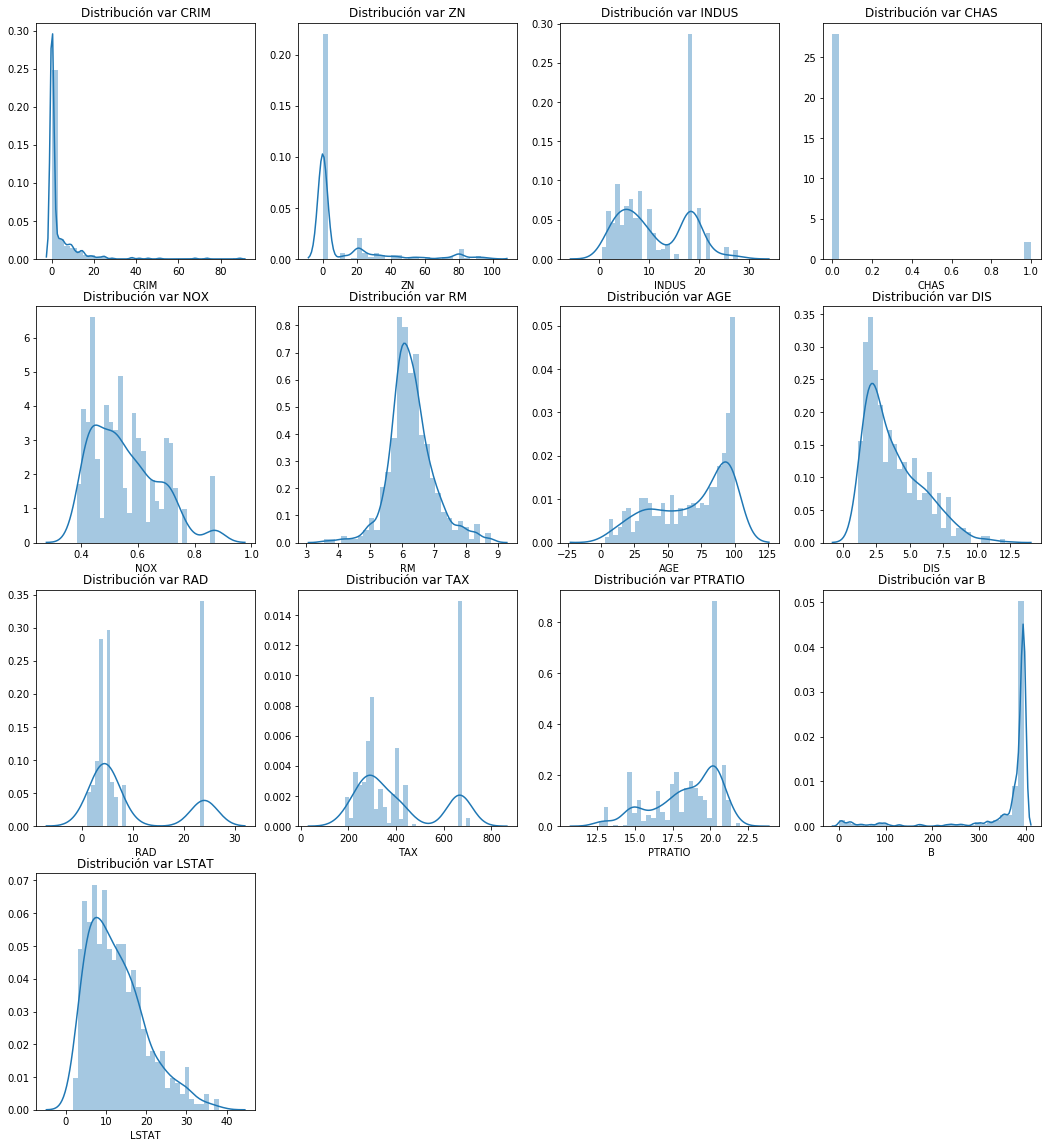

In [9]:
plt.figure(figsize=(18,20))
for i, column in enumerate(X.columns):
    plt.subplot(4, 4, i+1)
    sns.distplot(X[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

## Relación variable vs target: 

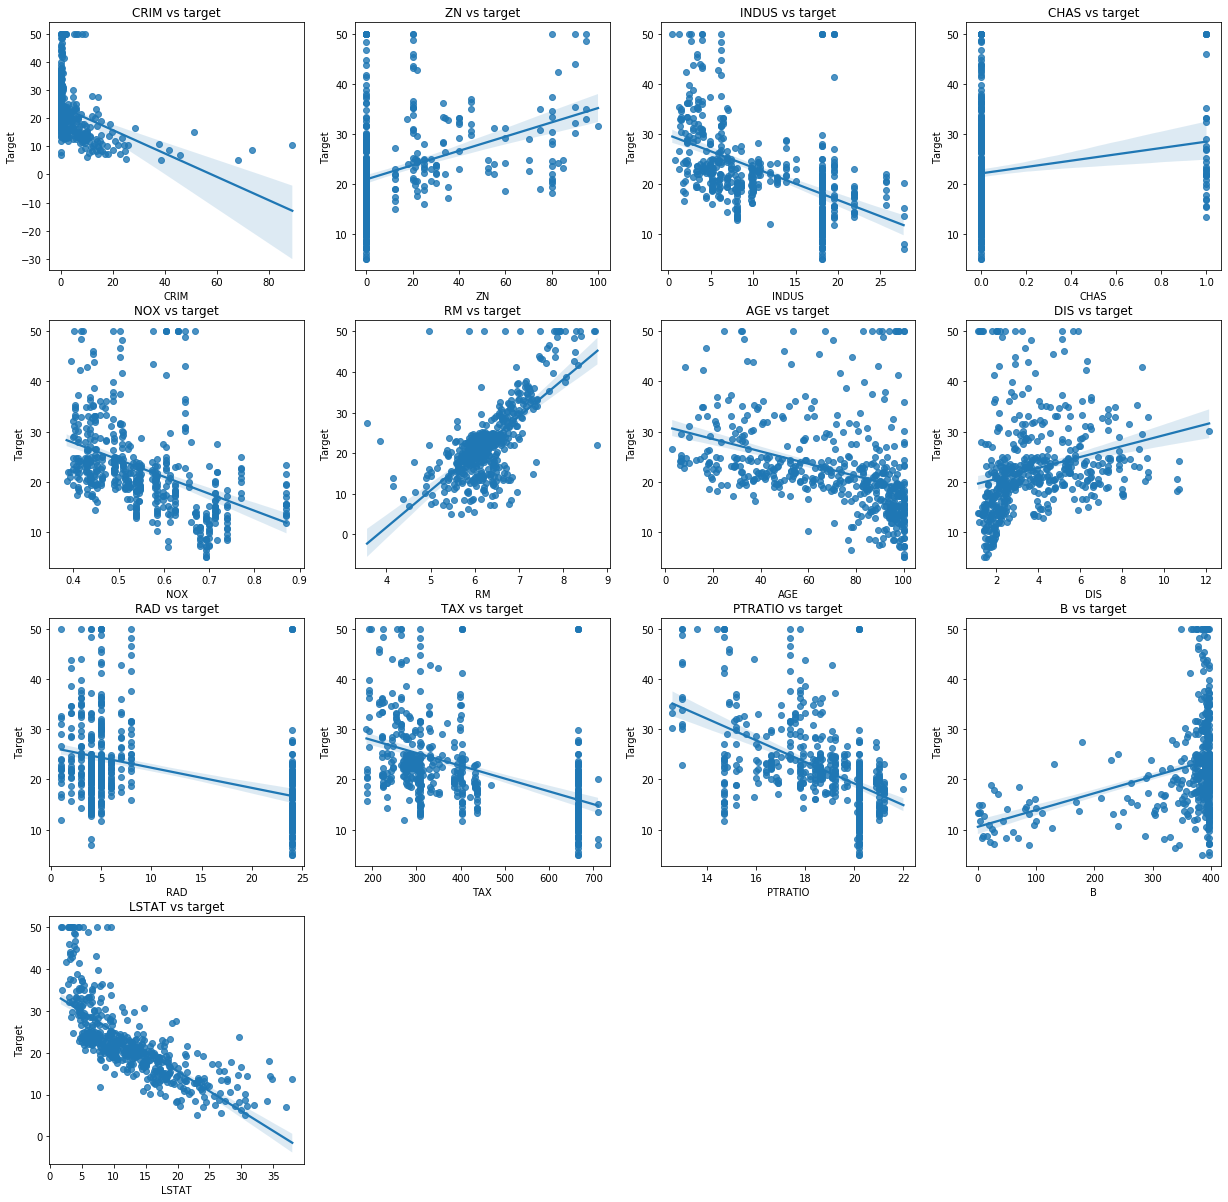

In [10]:
relaciones_vs_target_reg(X, Y)

## Matriz de correlaciones: 

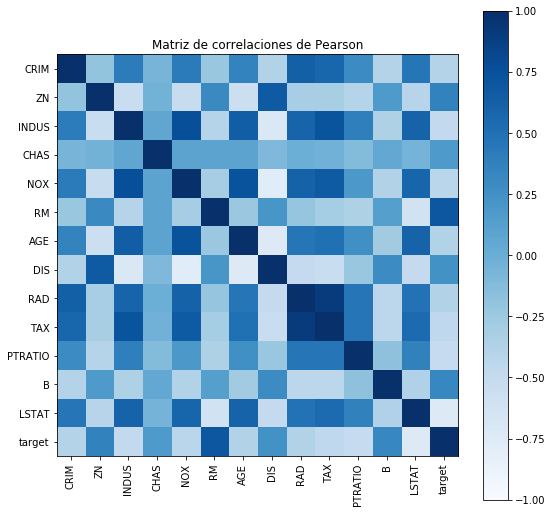

In [11]:
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

## Variables con mayor correlación con la target:

In [12]:
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
LSTAT,-0.737663
RM,0.695360
PTRATIO,-0.507787
INDUS,-0.483725
TAX,-0.468536
NOX,-0.427321
CRIM,-0.388305
RAD,-0.381626
AGE,-0.376955
ZN,0.360445


## Estandarización de los datos previa: 

Los modelos de redes neuronales pueden converger y obtener una buena solución incluso cuando los datos no están estandarizados. Sin embargo, para facilitar y acelerar el entrenamiento, los datos se suelen estandarizar.

In [13]:
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X)

## División en train y test: 

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size=0.2, random_state=0)

# Modelo de regresión con NN usando Tensorflow y Keras:

En el ejemplo de clasificación con redes neuronales se utiliza **sklearn**. Aunque existe una forma de realizar regresiones con redes neuronales en sklearn (<a href='https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html'>MLPRegressor</a>), en este caso utilizaremos Tensorflow y Keras, que son las herramientas que realmente se usan cuando una persona avanza en redes neuronales.  

Esto es porque Tensorflow nos aporta una flexibilidad que sklearn no lo hace. 

In [15]:
def constructor_modelo():
    # Definición del modelo
    modelo = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)])
    
    # Definición del optimizador
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    # Compilación del modelo
    modelo.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return modelo

Para crear un modelo de manera completa en Keras, existen dos partes que hay que configurar:

1. **La definición del modelo**: en este caso hemos definido el modelo como un modelo secuencial. Esto significa que las capas se agregan una tras otra. Hemos definido cuatro capas, tres densas con 64 neuronas cada una. La función de activación es una relu. Otra de ellas es la capa de salida, la cual cuanta con una sola neurona.
2. **Compilación del modelo**: para ello es necesario definir una función de coste (en este caso la MSE) y un optimizador. Para poder configurar los parámetros del optimizador ha sido necesario definirlo anteriormente.

In [16]:
model = constructor_modelo()

El modelo anteriormente creado podemos entrenarlo utilizando el método **.fit()**. Por defecto utiliza una sola época o epoch y todos los datos:

In [17]:
model.fit(X_train, Y_train)

Train on 404 samples
404/404 [==============================] - 1s 2ms/sample - loss: 534.7223 - mae: 21.1884 - mse: 534.7223


In [18]:
X_train.shape[1]

13

Si imprimimos el resumen del modelo podemos ver las cuatro capas que tiene y los parámetros en cada una de las capas.  Para la primera capa tendríamos un total de $$\#\ Parámetros = (64\ neuronas * 13\ variables\ input) + 64\ valores\ bias = 896$$

Y análogamente con el resto de capas:

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


Podemos predecir unos ejemplos para comprobar si la salida es correcta o hay que cambiar alguna configuración:

In [20]:
ejemplos = X_train[:10]
ejemplos_pred = model.predict(ejemplos)
ejemplos_pred

array([[3.5509443],
       [3.1370268],
       [2.4974983],
       [2.0920246],
       [3.165575 ],
       [1.8673748],
       [1.6757748],
       [2.8584843],
       [1.9217386],
       [2.2265568]], dtype=float32)

Parece que son coherentes las salidas.

# Entrenamiento del modelo

Entrene el modelo durante 1000 épocas y registre la precisión de entrenamiento y validación en el objeto history.

Se suele entrenar el modelo con más de una época. En este caso entrenamos el modelo con 1000 épocas. Además, hacemos uso del parámetro **callbacks**, que son una serie de funciones que se aplican en el entrenamiento para obtener estadísticas o parar el entrenamiento según un estado interno.

In [21]:
# Muestro un punto por cada una de las épocas completadas
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000
historico = model.fit(X_train, Y_train, 
                    epochs=EPOCHS,
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

En histórico se ha guardado un objeto con el entrenamiento de la red neuronal. Se puede visualizar el progreso del entrenamiento accediendo a sus métricas y la perdida guardadas con el atributo **.history**.

In [22]:
hist = pd.DataFrame(historico.history)
hist['epoch'] = historico.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.548744,0.578386,0.548744,12.088904,2.207442,12.088904,995
996,0.424005,0.464317,0.424005,11.790369,2.168899,11.790369,996
997,0.367166,0.437004,0.367166,12.142911,2.182772,12.142911,997
998,0.393808,0.457666,0.393808,10.968865,2.063398,10.968865,998
999,0.484609,0.527300,0.484609,12.425399,2.247377,12.425399,999


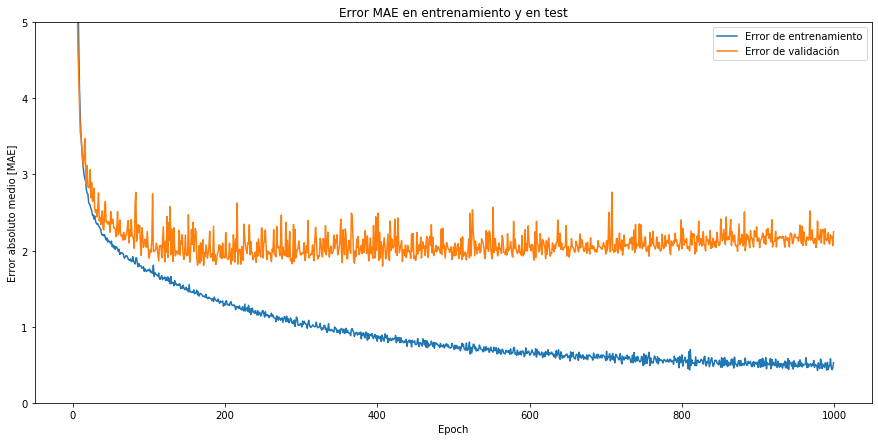

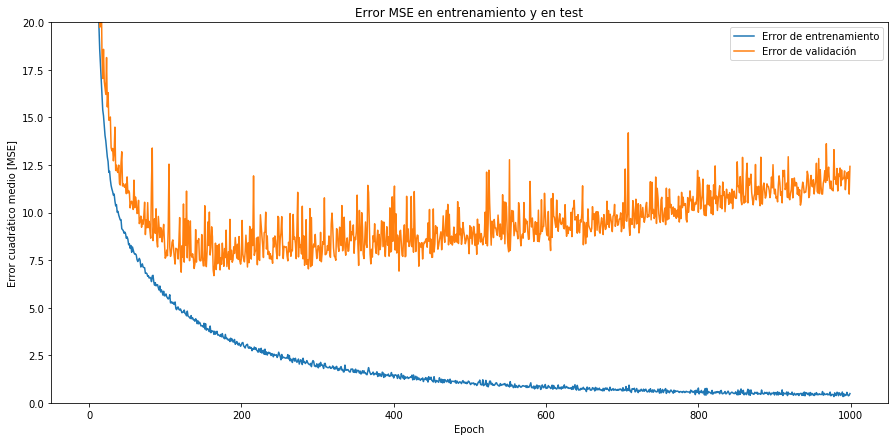

In [23]:
represento_historico(historico)

En las gráficas anteriores se puede ver poca mejora en los datos de validación a partir de un epoch, de hecho incluso se degrada. Esto se debe a que hay sobreajuste a partir de cierto punto, ya que el error en entrenamiento va disminuyendo pero en validación aumentando. 

Existe un **callback** del método de entrenamiento denominado **EarlyStopping** que para el entrenamiento si después de unas épocas determinadas no hay mejoraría en validación.


....................................................................................................
...

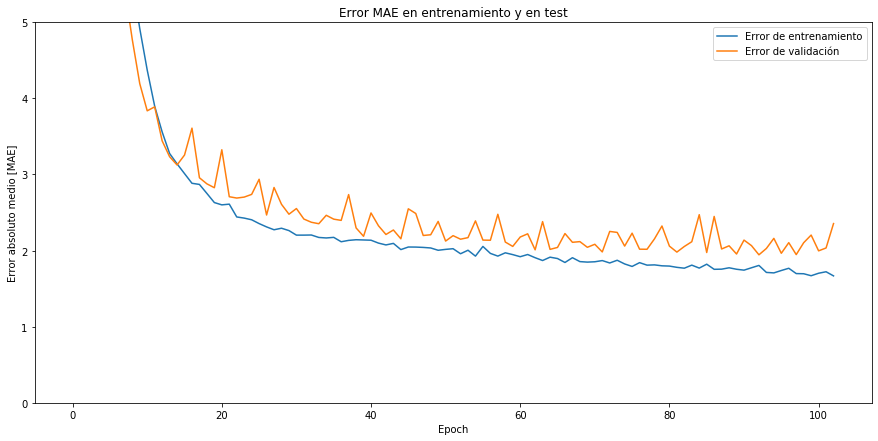

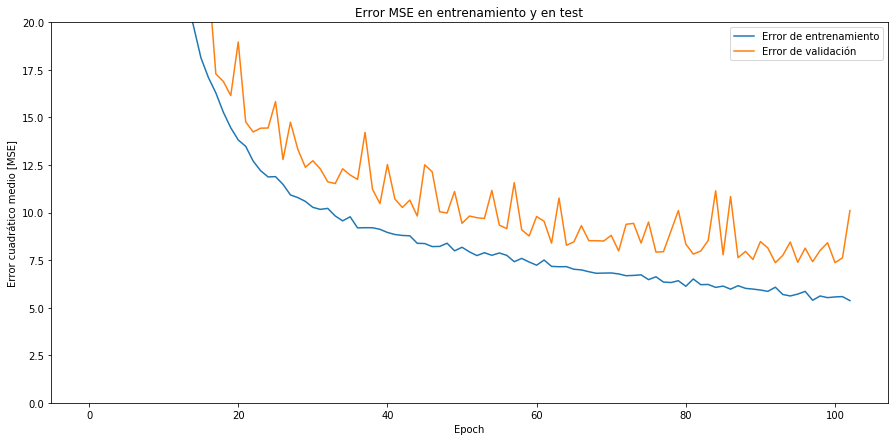

In [24]:
model = constructor_modelo()

# En monitor es el valor a monitorizar, que en este caso puede ser uno de los siguientes:
# [loss, mae, mse, val_loss, val_mae, val_mse]
# Patience es el número de épocas sin mejora antes de parar el entrenamiento
early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=10)

history = model.fit(X_train, Y_train, 
                    epochs=EPOCHS,
                    validation_split = 0.2, 
                    verbose=0, 
                    callbacks=[early_stop, PrintDot()])

represento_historico(history)

## Analizo errores:

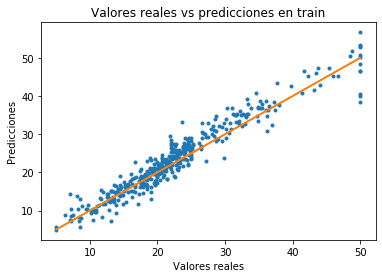

In [25]:
Y_train_pred = model.predict(X_train)
plt.title('Valores reales vs predicciones en train')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(Y_train, Y_train_pred, '.', Y_train, Y_train, '-')

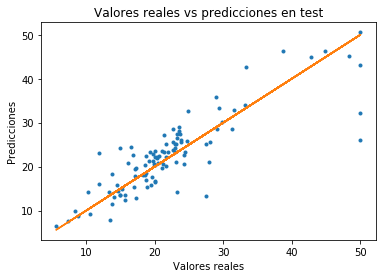

In [26]:
Y_test_pred = model.predict(X_test)
plt.title('Valores reales vs predicciones en test')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(Y_test, Y_test_pred, '.', Y_test, Y_test, '-')

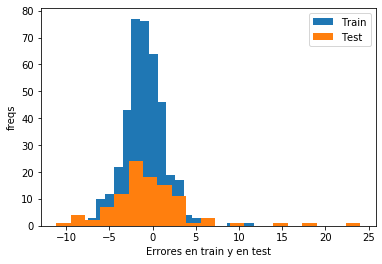

In [27]:
plt.xlabel('Errores en train y en test')
plt.ylabel('freqs')
plt.hist(Y_train - Y_train_pred.flatten(), bins=21, label='Train')
plt.hist(Y_test - Y_test_pred.flatten(), bins=21, label='Test')
_ = plt.legend()

In [28]:
error_mse_train = round(mean_squared_error(Y_train, Y_train_pred),2)
error_mse_test = round(mean_squared_error(Y_test, Y_test_pred),2)
print('El error cuadrático medio en train es: {}'.format(error_mse_train))
print('El error cuadrático medio en test es: {}'.format(error_mse_test))

El error cuadrático medio en train es: 7.27
El error cuadrático medio en test es: 23.96
